In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import torch

import importlib

import os

In [3]:
# Get Data
video_fn = "../VISEM_Simple_Dataset/11.mp4"
labels_fn = "../VISEM_Simple_Dataset/11_labels.csv"

frames = utils.loadVideo(video_fn)
labels = utils.loadDataFrame(labels_fn)


In [4]:
# Use the model to predict the sperm trajectory
from predictLocation import LitNetwork

checkpoint = torch.load('best_model.ckpt')

#print(checkpoint.keys())

model = LitNetwork(2,2)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model.to("cuda")

LitNetwork(
  (model): LSTMNetwork(
    (lstm): LSTM(2, 128, batch_first=True)
    (projection): Linear(in_features=128, out_features=2, bias=True)
  )
  (loss_func): MSELoss()
)

In [ ]:
# Get a random sperm in the data

sperm_id = np.random.choice(labels["sperm"].unique(), 1)[0]
sperm = labels[labels["sperm"] == sperm_id]
# Get the sperm trajectory
sperm = sperm[["frame", "x", "y"]].to_numpy()

# Get the video for the same frames
video_frames = frames[sperm[:, 0].astype(int)]
sperm = sperm[:, 1:3].astype(float)

# Normalize the x,y values
sperm[:, 0] = sperm[:, 0] / video_frames[0].shape[1]
sperm[:, 1] = sperm[:, 1] / video_frames[0].shape[0]

print(sperm.shape)


(337, 2)
[[0.4796875  0.0125    ]
 [0.4765625  0.0125    ]
 [0.471875   0.0125    ]
 [0.46875    0.0125    ]
 [0.4640625  0.0125    ]
 [0.4609375  0.01041667]
 [0.459375   0.01041667]
 [0.45625    0.00833333]
 [0.4546875  0.00833333]
 [0.4515625  0.00625   ]
 [0.4515625  0.00625   ]
 [0.45       0.00625   ]
 [0.45       0.00625   ]
 [0.45       0.00625   ]
 [0.4484375  0.00625   ]
 [0.446875   0.00625   ]
 [0.4453125  0.00625   ]
 [0.44375    0.00625   ]
 [0.44375    0.00625   ]
 [0.4421875  0.00625   ]
 [0.440625   0.00625   ]
 [0.440625   0.01041667]
 [0.4390625  0.0125    ]
 [0.4390625  0.01458333]
 [0.4375     0.01875   ]
 [0.4375     0.02083333]
 [0.4375     0.02291667]
 [0.4375     0.02708333]
 [0.4375     0.02916667]
 [0.4375     0.03125   ]
 [0.4359375  0.03541667]
 [0.4328125  0.0375    ]
 [0.428125   0.0375    ]
 [0.425      0.03958333]
 [0.421875   0.03958333]
 [0.41875    0.04166667]
 [0.4140625  0.04166667]
 [0.4109375  0.04375   ]
 [0.4078125  0.04166667]
 [0.403125   0.0

In [34]:
# Predict the sperm trajectory given the first 8 frames
predictions = sperm[:8].copy().tolist()

for i in range(8, len(sperm)):
    # Get the input data
    input_data = np.array(predictions[i-8:i]).reshape(1, 8, 2).astype(np.float32)
    input_data = torch.from_numpy(input_data).to("cuda")

    # Predict the sperm trajectory
    with torch.no_grad():
        prediction = model(input_data).cpu().numpy()

    # Append the prediction to the list
    predictions.append(prediction[0])

# Convert the predictions to a numpy array
predictions = np.array(predictions)

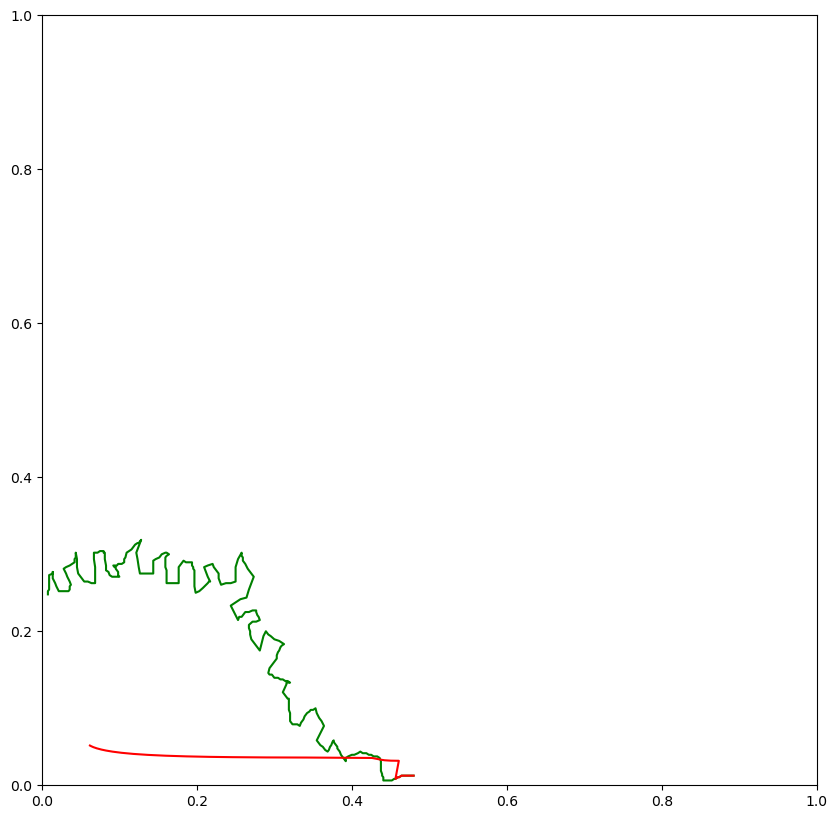

In [35]:
# Visualize the sperm trajectories
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

line1 = Line2D(sperm[:, 0], sperm[:, 1], color='green', label='Ground Truth')
line2 = Line2D(predictions[:, 0], predictions[:, 1], color='red', label='Predictions')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.add_line(line1)
ax.add_line(line2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()


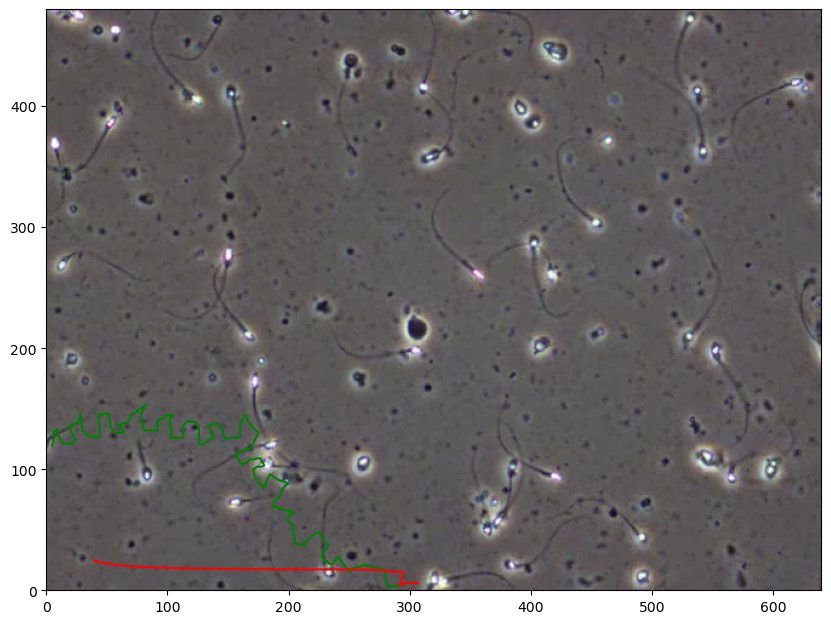

In [36]:
# Visualize on the last image of the video frame

image = video_frames[-1].copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape 

line1 = Line2D(sperm[:, 0]*width, sperm[:, 1]*height, color='green', label='Ground Truth')
line2 = Line2D(predictions[:, 0]*width, predictions[:, 1]*height, color='red', label='Predictions')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(image)
ax.add_line(line1)
ax.add_line(line2)
ax.set_xlim(0, width)
ax.set_ylim(0, height)

plt.show()